In [ ]:
# Copyright 2019 The Authors. All Rights Reserved.
#
# GNU General Public License v3.0
# Permissions of this strongest copyleft license are conditioned on 
# making available complete source code of licensed works and modifications, 
# which include larger works using a licensed work, under the same license. 
# Copyright and license notices must be preserved. 
# Contributors provide an express grant of patent rights. 
# When a modified version is used to provide a service over a network, 
# the complete source code of the modified version must be made available.
# ==============================================================================

# Title: Clustering of CRISPR spacers and virus genes using Autoencoders
# Author: Hyunjin Shim
# Date created: 20190813
# Email: jinenstar@hotmail.com

# Clustering CRISPR spacers using Autoencoders

- to analyze CRISPR spacers/units from https://crispi.genouest.org/
- to cluster CRISPR spacers/units by type
- to perform dimensionality reduction to identify patterns
- to visualize the results after each experimentation
- to assess the best possible network architecture

# Dataset description
- Archaea: 15591 spacers
- Bacteria 67838 spacers

# Step 1: Load and preprocess raw data

In [1]:
%env OPENBLAS_NUM_THREADS=6
%env OMP_NUM_THREADS=6
%env MKL_NUM_THREADS=6
%env NUMEXPR_NUM_THREADS=6

# Data
import os
import pandas as pd
import numpy as np

# Biopython
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord

# Regular expression
import re

# Plot
from pylab import *
import pylab as pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
import matplotlib.patches as mpatches

# Tensorflow
import tensorflow as tf
from keras.layers import Input, Dense
from keras.models import Model

# sklearn
from sklearn.model_selection import train_test_split


env: OPENBLAS_NUM_THREADS=6
env: OMP_NUM_THREADS=6
env: MKL_NUM_THREADS=6
env: NUMEXPR_NUM_THREADS=6


/home/jinenstar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jinenstar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jinenstar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jinenstar/

In [2]:
# location of raw data file
datapath = '/home/jinenstar/Data'
os.chdir(datapath)

# use Biopython to process and parse sequences
file_in ='archaea_spacer.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ar_spacer = []
    all_sequence_ar_spacer = []
    all_length_ar_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ar_spacer.append(seq_record.id)
        all_sequence_ar_spacer.append(seq_record.seq)
        all_length_ar_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ar_spacer = max(all_length_ar_spacer)
min_length_ar_spacer = min(all_length_ar_spacer)

In [3]:
print(seq_record)

ID: ref|NC_014537|
Name: ref|NC_014537|
Description: ref|NC_014537|  Vulcanisaeta distributa DSM 14429 chromosome 1601737-1601789
Number of features: 0
Seq('GCCGGCCCAGACTCATGTTACTGCAAACTCGAGGGGATTGGGTGCACGCAGAT', SingleLetterAlphabet())


In [4]:
print(min_length_ar_spacer)
print(all_length_ar_spacer.index(min_length_ar_spacer))
all_ID_ar_spacer[all_length_ar_spacer.index(min_length_ar_spacer)]

4
11232


'ref|NC_013769|'

In [5]:
print(max_length_ar_spacer)
print(all_length_ar_spacer.index(max_length_ar_spacer))
all_ID_ar_spacer[all_length_ar_spacer.index(max_length_ar_spacer)]

488
5094


'ref|NC_009634|'

In [6]:
all_ID_ar_spacer[-10:]

['ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|',
 'ref|NC_014537|']

In [7]:
all_sequence_ar_spacer[-10:]

[Seq('TAAAGCAGTCTATCAAGCATTCCGTGATTTCCTTAAGGAAAG', SingleLetterAlphabet()),
 Seq('AAAGATGGTGCCAGTATTGCCAGGCAATGAAATTCATGATGGTTT', SingleLetterAlphabet()),
 Seq('AATACAATAATAAGAGTCCCTGCGGACCCTAACGGTAAGCCGACAG', SingleLetterAlphabet()),
 Seq('TACTGTGAATGCGTTGAATGTCAACACAGCTACTTACCAGCAAA', SingleLetterAlphabet()),
 Seq('TCAGTAGTCATTATGATGTACTGCCAGACGGCCATTCCCCTATTGT', SingleLetterAlphabet()),
 Seq('GTGTCTAAAAATGACGATGCATGTGAGTGGTTTAAGGCGTGGTTGACA', SingleLetterAlphabet()),
 Seq('TCGTTAAAAGATACGGGGCAGGAAATAATGACATTTGAAGAGGGATTA', SingleLetterAlphabet()),
 Seq('ATTCCTAATCACCTACACCTCAAATTCGCAGGTAATGGAATAACTTCG', SingleLetterAlphabet()),
 Seq('AAAAACTTATAAATCAGTCCTGAGCAAAAACAATGTATGAAAGAAA', SingleLetterAlphabet()),
 Seq('GCCGGCCCAGACTCATGTTACTGCAAACTCGAGGGGATTGGGTGCACGCAGAT', SingleLetterAlphabet())]

In [8]:
# location of raw data file
datapath = '/home/jinenstar/Data'
os.chdir(datapath)

# use Biopython to process and parse sequences
file_in ='bacteria_spacer.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ba_spacer = []
    all_sequence_ba_spacer = []
    all_length_ba_spacer = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ba_spacer.append(seq_record.id)
        all_sequence_ba_spacer.append(seq_record.seq)
        all_length_ba_spacer.append(len(seq_record.seq))

# find maximum seq length
max_length_ba_spacer = max(all_length_ba_spacer)
min_length_ba_spacer = min(all_length_ba_spacer)

In [9]:
print(seq_record)

ID: ref|NC_022900|
Name: ref|NC_022900|
Description: ref|NC_022900|  Zymomonas mobilis subsp. mobilis str. CP4 = NRRL B-14023 1794820-1794851
Number of features: 0
Seq('GCCAATTTTTCAGCATAACGTCGCAGCTCAAC', SingleLetterAlphabet())


In [10]:
print(min_length_ba_spacer)
print(all_length_ba_spacer.index(min_length_ba_spacer))
all_ID_ba_spacer[all_length_ba_spacer.index(min_length_ba_spacer)]

2
47107


'ref|NC_015379|'

In [11]:
print(max_length_ba_spacer)
print(all_length_ba_spacer.index(max_length_ba_spacer))
all_ID_ba_spacer[all_length_ba_spacer.index(max_length_ba_spacer)]

946
65581


'ref|NC_022576|'

In [12]:
all_ID_ba_spacer[-10:]

['ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|',
 'ref|NC_022900|']

In [13]:
all_sequence_ba_spacer[-10:]

[Seq('CGACCGTTACGATCAACGATATCGGCGCGCGCCTGCAACGGCGCAACGGGTGGA...GTG', SingleLetterAlphabet()),
 Seq('GAAGGATTTTTGCCCGGGACAAAAT', SingleLetterAlphabet()),
 Seq('CAGCTTTGCGCTTTAGCGTTGCGG', SingleLetterAlphabet()),
 Seq('CTCCAAGAAGAGATCGCAACCGAG', SingleLetterAlphabet()),
 Seq('AAAAGACACGATATGCGATGTGGC', SingleLetterAlphabet()),
 Seq('GCGTGTCTTCGATAATAACTCTGCGACGATC', SingleLetterAlphabet()),
 Seq('CGACAGTCGGGCCGGATACCATGATCCGAGT', SingleLetterAlphabet()),
 Seq('AAGGTAATATTATCGTCACTGACAAGCAAGG', SingleLetterAlphabet()),
 Seq('TCTTGTGACATTGCTGGCTTTGCTTGAGCAT', SingleLetterAlphabet()),
 Seq('GCCAATTTTTCAGCATAACGTCGCAGCTCAAC', SingleLetterAlphabet())]

In [14]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ar_spacer = []
for i in range(len(all_sequence_ar_spacer)):
    all_sequence_no_ar_spacer.append(str(all_sequence_ar_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0'))

In [15]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ba_spacer = []
for i in range(len(all_sequence_ba_spacer)):
    all_sequence_no_ba_spacer.append(str(all_sequence_ba_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('B','0').replace('H','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0'))

In [16]:
all_sequence_no = all_sequence_no_ar_spacer + all_sequence_no_ba_spacer

In [17]:
# dictionary to DataFrame
all_ID = all_ID_ar_spacer + all_ID_ba_spacer
all_length = all_length_ar_spacer + all_length_ba_spacer

all_label_ar_spacer = [0] * len(all_sequence_ar_spacer)
all_label_ba_spacer = [1] * len(all_sequence_ba_spacer)
all_label = all_label_ar_spacer + all_label_ba_spacer

all_keyword_ar_spacer = ['Archaea'] * len(all_sequence_ar_spacer)
all_keyword_ba_spacer = ['Bacteria'] * len(all_sequence_ba_spacer)
all_keyword = all_keyword_ar_spacer + all_keyword_ba_spacer

d = {'ID':all_ID, 'Category':all_keyword, 'Label':all_label, 'Length':all_length}
all_data = pd.DataFrame(d)

In [18]:
all_data

,ID,Category,Label,Length
0,ref|NC_015518|,Archaea,0,33
1,ref|NC_015518|,Archaea,0,35
2,ref|NC_015518|,Archaea,0,35
3,ref|NC_015518|,Archaea,0,34
4,ref|NC_015518|,Archaea,0,36
5,ref|NC_015518|,Archaea,0,34
6,ref|NC_015518|,Archaea,0,34
7,ref|NC_015518|,Archaea,0,35
8,ref|NC_015518|,Archaea,0,34
9,ref|NC_015518|,Archaea,0,34


In [19]:
# use Biopython to process and parse sequences
file_in ='sequence_arc.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ar_genes = []
    all_sequence_ar_genes = []
    all_length_ar_genes = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ar_genes.append(seq_record.id)
        all_sequence_ar_genes.append(seq_record.seq)
        all_length_ar_genes.append(len(seq_record.seq))

# find maximum seq length
max_length_ar_genes = max(all_length_ar_genes)
min_length_ar_genes = min(all_length_ar_genes)

In [20]:
print(seq_record)

ID: lcl|NC_001338.1_gene_32
Name: lcl|NC_001338.1_gene_32
Description: lcl|NC_001338.1_gene_32 [locus_tag=SSV-1p33] [db_xref=GeneID:2559661] [location=15223..15465] [gbkey=Gene]
Number of features: 0
Seq('ATGGCTAAAAAGAACGGCTTAACAGAACTAGAGCAATTAAAGAAAGAGAACGAA...GAA', SingleLetterAlphabet())


In [21]:
print(min_length_ar_genes)
print(all_length_ar_genes.index(min_length_ar_genes))
all_ID_ar_genes[all_length_ar_genes.index(min_length_ar_genes)]

25
169


'lcl|NC_042059.1_gene_5'

In [22]:
print(max_length_ar_genes)
print(all_length_ar_genes.index(max_length_ar_genes))
all_ID_ar_genes[all_length_ar_genes.index(max_length_ar_genes)]

7068
2713


'lcl|NC_020077.1_gene_31'

In [23]:
all_ID_ar_genes[-10:]

['lcl|NC_001338.1_gene_23',
 'lcl|NC_001338.1_gene_24',
 'lcl|NC_001338.1_gene_25',
 'lcl|NC_001338.1_gene_26',
 'lcl|NC_001338.1_gene_27',
 'lcl|NC_001338.1_gene_28',
 'lcl|NC_001338.1_gene_29',
 'lcl|NC_001338.1_gene_30',
 'lcl|NC_001338.1_gene_31',
 'lcl|NC_001338.1_gene_32']

In [24]:
all_sequence_ar_genes[-10:]

[Seq('ATGACGGACGCAATCAGTTTAGCCTTGCAAACGGGCTTAGGGCCGGTGGTAGGG...TAA', SingleLetterAlphabet()),
 Seq('ATGGGGACTAAGTTAGTCGTTTACGTCTTATTGTTTGACGTCTTCCTATCGTTA...TGA', SingleLetterAlphabet()),
 Seq('GAAGCAACCAACATAGGCGTATTGTTGGGCTTATTCATCTTCATACTAATAGGT...ACT', SingleLetterAlphabet()),
 Seq('ATGGAAATCAGTTTAAAGCCAATCATTTTTTTGGTCGTTTTTATCATCGTAGGG...TGA', SingleLetterAlphabet()),
 Seq('ATGAAGTGGGTGCAAAAGGCGATAAAGAGACCCGGGAGGGTACATCGCTACCTT...TAG', SingleLetterAlphabet()),
 Seq('ATGAGTGCGTTAGGGGATGTAATCTACATCTTGGGTTTTCTCTTTCCGGCTTTA...TGA', SingleLetterAlphabet()),
 Seq('ATGAGGTGGGGTAGAAGAGATGATAGGGATACCGGCAAAATACTTCGAAATAGG...TAA', SingleLetterAlphabet()),
 Seq('ATGTCTGATGGGAAACTCCTTTCTGCTTTCGAGGAGGAATTAAGAAAAGCCCAA...TAA', SingleLetterAlphabet()),
 Seq('ATGGTCTCAGTAACAGAAATAATAACATATGGACGAGAAGCAATAGAAAGAATA...TAA', SingleLetterAlphabet()),
 Seq('ATGGCTAAAAAGAACGGCTTAACAGAACTAGAGCAATTAAAGAAAGAGAACGAA...GAA', SingleLetterAlphabet())]

In [25]:
# use Biopython to process and parse sequences
file_in ='sequence_bac.txt'

with open(file_in) as fasta_file:  # Will close handle cleanly
    all_ID_ba_genes = []
    all_sequence_ba_genes = []
    all_length_ba_genes = []
    for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
        # remove .id from .description record (remove all before first space)
        #seq_record.description=' '.join(seq_record.description.split()[1:])
        # a list of IDs and sequences
        all_ID_ba_genes.append(seq_record.id)
        all_sequence_ba_genes.append(seq_record.seq)
        all_length_ba_genes.append(len(seq_record.seq))

# find maximum seq length
max_length_ba_genes = max(all_length_ba_genes)
min_length_ba_genes = min(all_length_ba_genes)

In [26]:
print(seq_record)

ID: lcl|NC_001798.2_gene_79
Name: lcl|NC_001798.2_gene_79
Description: lcl|NC_001798.2_gene_79 [gene=RS1] [locus_tag=HHV2p01] [db_xref=GeneID:1487290] [location=149640..153715] [gbkey=Gene]
Number of features: 0
Seq('ATGTCGGCGGAGCAGCGGAAGAAGAAGAAGACGACGACGACGACGCAGGGCCGC...AAA', SingleLetterAlphabet())


In [27]:
print(min_length_ba_genes)
print(all_length_ba_genes.index(min_length_ba_genes))
all_ID_ba_genes[all_length_ba_genes.index(min_length_ba_genes)]

1
370717


'lcl|NC_001416.1_gene_32'

In [28]:
print(max_length_ba_genes)
print(all_length_ba_genes.index(max_length_ba_genes))
all_ID_ba_genes[all_length_ba_genes.index(max_length_ba_genes)]

262388
288948


'lcl|NC_016163.1_gene_1'

In [29]:
all_ID_ba_genes[-10:]

['lcl|NC_001798.2_gene_70',
 'lcl|NC_001798.2_gene_71',
 'lcl|NC_001798.2_gene_72',
 'lcl|NC_001798.2_gene_73',
 'lcl|NC_001798.2_gene_74',
 'lcl|NC_001798.2_gene_75',
 'lcl|NC_001798.2_gene_76',
 'lcl|NC_001798.2_gene_77',
 'lcl|NC_001798.2_gene_78',
 'lcl|NC_001798.2_gene_79']

In [30]:
all_sequence_ba_genes[-10:]

[Seq('ATGGATCGGTATGCCGTTCGGACCTGGGGGATTGTGGGAATCCTCGGGTGTGCT...AAA', SingleLetterAlphabet()),
 Seq('ATGGGGCGTTTGACCTCCGGCGTCGGGACGGCGGCCCTGCTAGTTGTCGCGGTG...AAA', SingleLetterAlphabet()),
 Seq('ATGCCCGGCCGCTCGCTGCAGGGCCTGGCGATCCTGGGCCTGTGGGTCTGCGCC...AAA', SingleLetterAlphabet()),
 Seq('ATGGCTCGCGGGGCCGGGTTGGTGTTTTTTGTTGGAGTTTGGGTCGTATCGTGC...CGC', SingleLetterAlphabet()),
 Seq('ATGGATCCGGCTTTGAGATCTTATCACCAACGGCTCCGTCTGTATACCCCCATA...CGC', SingleLetterAlphabet()),
 Seq('ATGACCTCCCGGCCCGCCGACCAAGACTCGGTGCGTTCCAGCGCGTCGGTGCCG...CGC', SingleLetterAlphabet()),
 Seq('ATGTCTTGGGCCCTGAAAACGACGGACATGTTTCTGGATTCTTCGCGGTGCACA...AAA', SingleLetterAlphabet()),
 Seq('ATGGCATCCGGGGTTTCCCCGGCCCACCCCCAAACCCCGGTTGGGGCGGGCAGC...AAA', SingleLetterAlphabet()),
 Seq('ATGATCCGGCGGCGGGGAAACGTGGAGATTCGGGTCTACTACGAGTCTGTGCGG...AAA', SingleLetterAlphabet()),
 Seq('ATGTCGGCGGAGCAGCGGAAGAAGAAGAAGACGACGACGACGACGCAGGGCCGC...AAA', SingleLetterAlphabet())]

In [31]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ar_spacer = []
for i in range(len(all_sequence_ar_spacer)):
    all_sequence_no_ar_spacer.append(str(all_sequence_ar_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('V','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0').replace('v','0'))

In [32]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ba_spacer = []
for i in range(len(all_sequence_ba_spacer)):
    all_sequence_no_ba_spacer.append(str(all_sequence_ba_spacer[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('V','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0').replace('v','0'))

In [33]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ar_genes = []
for i in range(len(all_sequence_ar_genes)):
    all_sequence_no_ar_genes.append(str(all_sequence_ar_genes[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('V','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0').replace('v','0'))

In [34]:
# genetic sequence into numerical values: replace('A','1').replace('C','2').replace('G','3').replace('T','4').replace('N','0').replace('n','0')
all_sequence_no_ba_genes = []
for i in range(len(all_sequence_ba_genes)):
    all_sequence_no_ba_genes.append(str(all_sequence_ba_genes[i]).replace('T','1').replace('A','2').replace('G','3').replace('C','4').replace('t','1').replace('a','2').replace('g','3').replace('c','4').replace('N','0').replace('n','0').replace('K','0').replace('Y','0').replace('M','0').replace('R','0').replace('W','0').replace('S','0').replace('H','0').replace('B','0').replace('D','0').replace('V','0').replace('k','0').replace('y','0').replace('m','0').replace('r','0').replace('w','0').replace('s','0').replace('b','0').replace('h','0').replace('d','0').replace('v','0'))

In [35]:
all_sequence_no = all_sequence_no_ar_spacer + all_sequence_no_ba_spacer + all_sequence_no_ar_genes + all_sequence_no_ba_genes

In [36]:
# dictionary to DataFrame
all_ID = all_ID_ar_spacer + all_ID_ba_spacer + all_ID_ar_genes + all_ID_ba_genes
all_length = all_length_ar_spacer + all_length_ba_spacer + all_length_ar_genes + all_length_ba_genes

all_label_ar_spacer = [0] * len(all_sequence_ar_spacer)
all_label_ba_spacer = [1] * len(all_sequence_ba_spacer)
all_label_ar_genes = [2] * len(all_sequence_ar_genes)
all_label_ba_genes = [3] * len(all_sequence_ba_genes)
all_label = all_label_ar_spacer + all_label_ba_spacer + all_label_ar_genes + all_label_ba_genes

all_keyword_ar_spacer = ['ArchaeaU'] * len(all_sequence_ar_spacer)
all_keyword_ba_spacer = ['BacteriaU'] * len(all_sequence_ba_spacer)
all_keyword_ar_genes = ['ArchaeaG'] * len(all_sequence_ar_genes)
all_keyword_ba_genes = ['BacteriaG'] * len(all_sequence_ba_genes)
all_keyword = all_keyword_ar_spacer + all_keyword_ba_spacer + all_keyword_ar_genes + all_keyword_ba_genes

d = {'ID':all_ID, 'Category':all_keyword, 'Label':all_label, 'Length':all_length}
all_data = pd.DataFrame(d)

In [37]:
all_data

,ID,Category,Label,Length
0,ref|NC_015518|,ArchaeaU,0,33
1,ref|NC_015518|,ArchaeaU,0,35
2,ref|NC_015518|,ArchaeaU,0,35
3,ref|NC_015518|,ArchaeaU,0,34
4,ref|NC_015518|,ArchaeaU,0,36
5,ref|NC_015518|,ArchaeaU,0,34
6,ref|NC_015518|,ArchaeaU,0,34
7,ref|NC_015518|,ArchaeaU,0,35
8,ref|NC_015518|,ArchaeaU,0,34
9,ref|NC_015518|,ArchaeaU,0,34


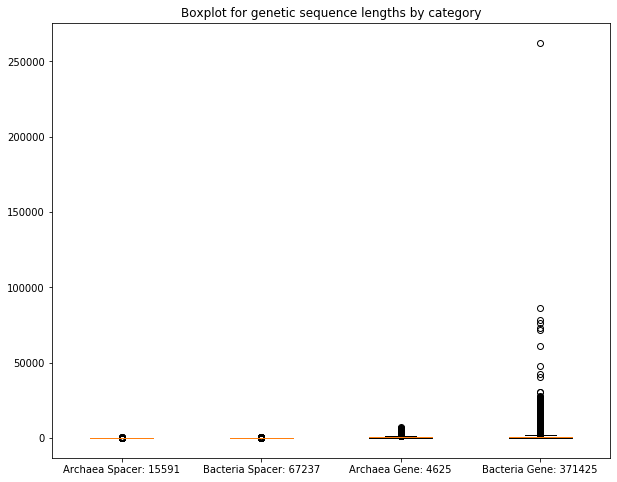

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

data_archaeaU = all_data[all_data['Label']==0]
len_archaeaU = len(data_archaeaU)
data_bacteriaU = all_data[all_data['Label']==1]
len_bacteriaU = len(data_bacteriaU)
data_archaeaG = all_data[all_data['Label']==2]
len_archaeaG = len(data_archaeaG)
data_bacteriaG = all_data[all_data['Label']==3]
len_bacteriaG = len(data_bacteriaG)

# boxplot
data_plot = [data_archaeaU['Length'],data_bacteriaU['Length'],data_archaeaG['Length'],data_bacteriaG['Length']]
fig1, ax1 = plt.subplots(figsize=(10,8))
ax1.set_title('Boxplot for genetic sequence lengths by category')
ax1.boxplot(data_plot)
plt.xticks([1,2,3,4],['Archaea Spacer: '+str(len_archaeaU),'Bacteria Spacer: '+str(len_bacteriaU),'Archaea Gene: '+str(len_archaeaG),'Bacteria Gene: '+str(len_bacteriaG)])
plt.show()

In [39]:
# numpy array of sequences of a fixed length

median_length = 1200
# define numpy array with dimension (1,227,759 proteins, median=500 features)
all_sequence_no_dim = np.zeros(shape=(len(all_sequence_no),median_length))
# define dimension of features
no_dim_features = median_length

print(all_sequence_no_dim.shape)

for n in range(len(all_sequence_no)):
    # convert char sequence to digit sequence
    sequence_digits=[int(d) for d in str(all_sequence_no[n])]
    # store digit sequence into numpy with right dimension
    if len(sequence_digits) <= median_length:
        all_sequence_no_dim[n,0:len(sequence_digits)]=sequence_digits[0:len(sequence_digits)]
    else:
        all_sequence_no_dim[n]=sequence_digits[0:median_length]   

(458878, 1200)


In [40]:
print(all_sequence_no_dim[10000])
print(all_sequence_no_dim[458877])

[4. 1. 2. ... 0. 0. 0.]
[2. 1. 3. ... 4. 4. 4.]


In [41]:
def reproduce(seed_number):
    import tensorflow as tf
    import random
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(seed_number)
    random.seed(seed_number)
    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    #from keras import backend as K
    tf.set_random_seed(seed_number)
    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    tf.keras.backend.set_session(sess)

In [42]:
from sklearn.preprocessing import MinMaxScaler
#scale data 0-1
min_max_scaler = MinMaxScaler( feature_range=(0,1), copy=True )
all_sequence_no_dim_norm = min_max_scaler.fit_transform(all_sequence_no_dim)

In [43]:
# what type of gene subpopulations exist in data? Let's do PCA
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
Y = pca.fit_transform(all_sequence_no_dim_norm)
#Y = pca.fit_transform(all_sequence_no_dim)

# 3D PCA
pca_3D = PCA(n_components=3)
Y_3D = pca.fit_transform(all_sequence_no_dim_norm)

In [58]:
#label_name = {1:"Host Archaea", 2:"Host Bacteria"}
label_color_map = {0:'orange',1:'blue',2:'green',3:'red'}
label_color = [label_color_map[c] for c in all_label]

# 2D PCA plot
fig = plt.figure(figsize=(10,8))
ax = plt.scatter(Y[:,0], Y[:,1], s=1, c=label_color, alpha=0.05)

plt.xticks([])
plt.yticks([])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ar_spacer_patch = mpatches.Patch(color='orange', label='Archaea Spacer')
ba_spacer_patch = mpatches.Patch(color='blue', label='Bacteria Spacer')
ar_gene_patch = mpatches.Patch(color='green', label='Archaea Gene')
ba_gene_patch = mpatches.Patch(color='red', label='Bacteria Gene')
plt.legend(handles=[ar_spacer_patch,ba_spacer_patch,ar_gene_patch,ba_gene_patch],loc='upper right')

plt.show()
#fig.savefig('PCA_min_features_acr_2D.pdf')

ValueError: Can only tuple-index with a MultiIndex

<Figure size 720x576 with 0 Axes>

# Step 2: Create, compile, fit autoencoder model
- use Keras, a high-level neural networks API that runs on top of librares like TensorFlow.

In [45]:
#split the data in training and test sets
Y = pd.Series(all_label)

x_train, x_test, y_train_og, y_test = train_test_split(all_sequence_no_dim_norm, Y, test_size=0.01, random_state=10)
print('Training set has', x_train.shape[0], 'rows and', x_train.shape[1], 'columns')
print('Test set has', x_test.shape[0], 'rows and', x_test.shape[1], 'columns')

Training set has 454289 rows and 1200 columns
Test set has 4589 rows and 1200 columns


In [46]:
y_train = pd.Series(y_train_og).values

In [55]:
#plot original data, reconstructed data, residuals
def plot_reconstruction(data_norm, data_dec):
    plt.figure(figsize=(30,20))
    plt.subplot(3,1,1)
    ax1 = plt.imshow(data_norm, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax1)
    plt.title('Original data', fontsize=25)
    plt.subplot(3,1,2)
    ax2 = plt.imshow(data_dec, cmap="seismic", aspect="auto", vmin=0, vmax=1)
    cbar = plt.colorbar(ax2)
    plt.title('Recondstruction', fontsize=25)
    plt.subplot(3,1,3)
    ax3 = plt.imshow(data_norm-data_dec, cmap="seismic", aspect="auto", vmin=-1, vmax=1)
    plt.gca().set_xticks(range(no_dim_features))
#    plt.gca().set_xticklabels(markers, fontsize=20)
    cbar = plt.colorbar(ax3)
    plt.title('Residuals', fontsize=25)
    plt.show()
    # print residual values
    print(sum(abs(data_norm-data_dec)))
    
#plot training history
def plot_history(autoencoder):
    fig = plt.figure(figsize=(6,4))
    plt.plot(autoencoder.history.history['loss'])
    plt.plot(autoencoder.history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss function')
    plt.legend(['Loss', 'Validation loss'])
    plt.show()

#plot reduced dimensions
def plot_encoded(x_train_encoded, y_train): 
    #label_name = {1:"Host Archaea", 2:"Host Bacteria"}
    label_color_map = {0:'orange',1:'blue',2:'red',3:'green'}
    label_color = [label_color_map[c] for c in y_train]

    ar_spacer_patch = mpatches.Patch(color='orange', label='Archaea Spacer')
    ba_spacer_patch = mpatches.Patch(color='blue', label='Bacteria Spacer')
    ar_gene_patch = mpatches.Patch(color='red', label='Archaea Gene')
    ba_gene_patch = mpatches.Patch(color='green', label='Bacteria Gene')
    
    fig = plt.figure(figsize=(10,8))
    ax = plt.scatter(x_train_encoded[:,0], x_train_encoded[:,2], s=5, c=label_color, alpha=0.05)
    #cbar = plt.colorbar(ax, ticks=range(21))
    #cbar.ax.set_yticklabels(cell_types['cell type name'])
    #ax.set_facecolor('white')

    plt.legend(handles=[ar_spacer_patch,ba_spacer_patch,ar_gene_patch,ba_gene_patch],loc='upper right')

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

def plot_encoded_3D(x_train_encoded, y_train):
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection='3d')

    label_color_map = {0:'orange',1:'blue',2:'red',3:'green'}
    label_color = [label_color_map[c] for c in y_train]
    
    ax.scatter(x_train_encoded[:,0], \
               x_train_encoded[:,1], \
               x_train_encoded[:,2], \
               c=label_color, alpha=0.1)

    ax.set_xlabel('Dim 1')
    ax.set_ylabel('Dim 2')
    ax.set_zlabel('Dim 3')
    
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    pylab.title("3D Embedding: ")
    pylab.show()
    return

In [49]:
reproduce(10)

#set dimensions of input and hidden layer
input_dim = no_dim_features
intermediate_1 = 300
intermediate_2 = 100
intermediate_3 = 20
latent_dim = 3

input_data = tf.keras.layers.Input(shape=(input_dim,))
#encode the input with a dense layer
encoded_1 = tf.keras.layers.Dense(intermediate_1, activation='relu')(input_data)
encoded_2 = tf.keras.layers.Dense(intermediate_2, activation='relu')(encoded_1)
encoded_3 = tf.keras.layers.Dense(intermediate_3, activation='relu')(encoded_2)
encoded_4 = tf.keras.layers.Dense(latent_dim, activation='relu')(encoded_3)
#decode the encoded input to its reconstruction
decoded_1 = tf.keras.layers.Dense(intermediate_3, activation='relu')(encoded_4)
decoded_2 = tf.keras.layers.Dense(intermediate_2, activation='relu')(decoded_1)
decoded_3 = tf.keras.layers.Dense(intermediate_1, activation='relu')(decoded_2)
decoded_4 = tf.keras.layers.Dense(input_dim, activation='sigmoid')(decoded_3)

#autoencoder_2 maps the input to the output
autoencoder_4 = tf.keras.models.Model(input_data, decoded_4)

#encoder_2 maps the input to the latent representation
encoder_4 = tf.keras.models.Model(input_data, encoded_4)

#compile the model and set the desired optimizer and loss function
autoencoder_4.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_4.summary()
autoencoder_4.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=False,
                validation_data=(x_test, x_test))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1200)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 300)               360300    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_10 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 63        
_________________________________________________________________
dense_12 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_13 (Dense)             (None, 100)               2100

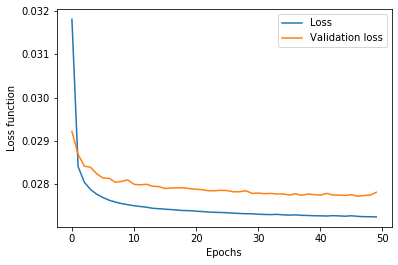

In [50]:
plot_history(autoencoder_4)

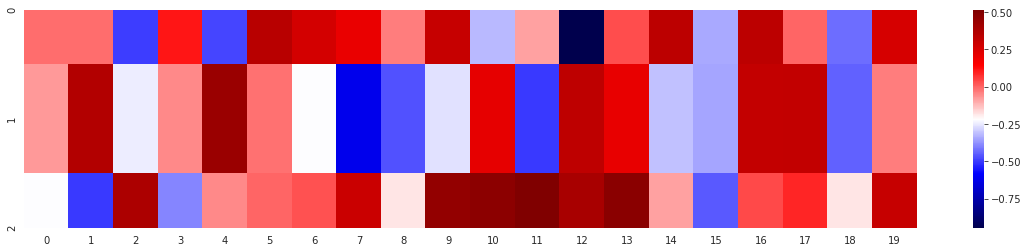

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

#get the weights of the hidden layer
weights=autoencoder_4.layers[5].get_weights()
#visualize the weights
plt.figure(figsize=(20,4))
sns.heatmap(data=weights[0], cmap='seismic')
#plt.gca().set_xticklabels(range(no_dim_features))
plt.show()

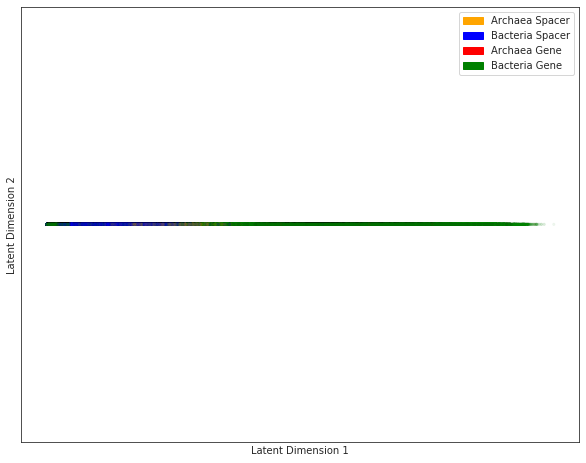

In [56]:
#encoder input into latent dimensions
x_enc_4 = encoder_4.predict(x_train, batch_size=256)
plot_encoded(x_enc_4, y_train)

W0828 10:37:16.091995 139848621170816 legend.py:1282] No handles with labels found to put in legend.


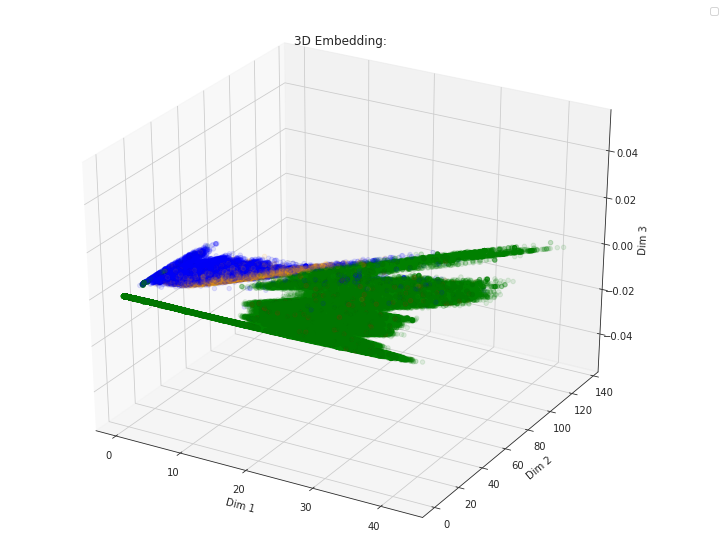

In [57]:
plot_encoded_3D(x_enc_4, y_train_og)

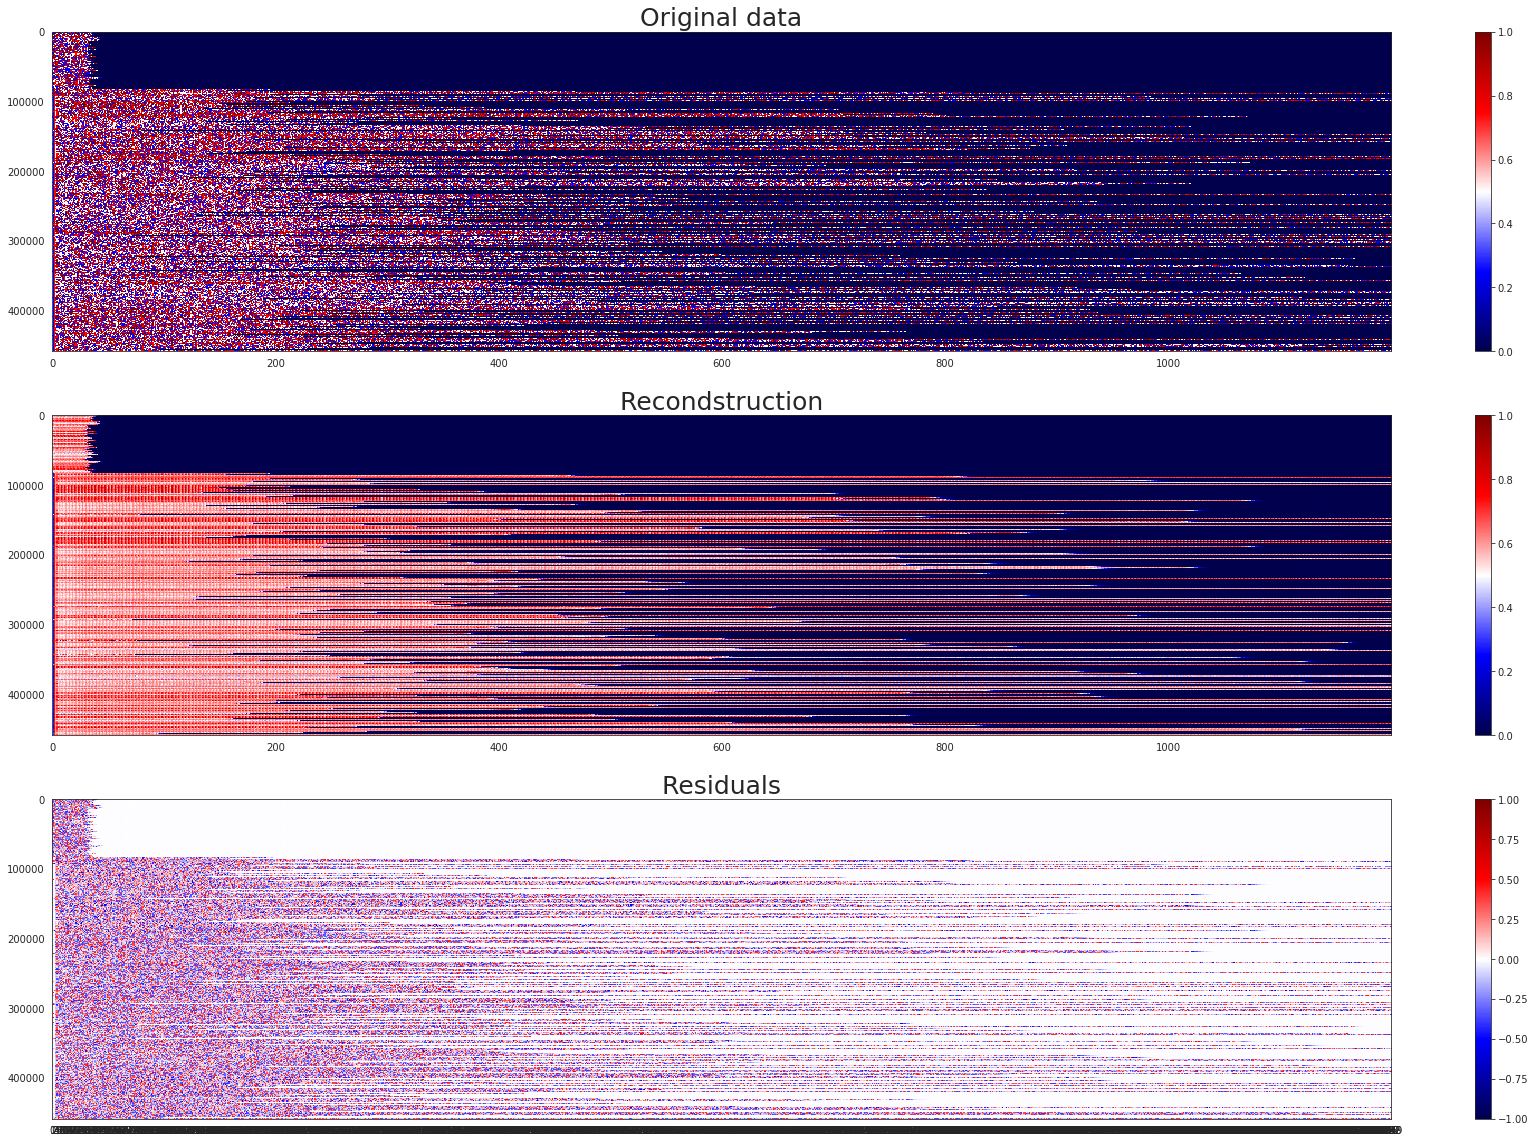

49221910.71355438


In [54]:
#reconstruct the data
data_dec_4 = autoencoder_4.predict(all_sequence_no_dim_norm)
plot_reconstruction(all_sequence_no_dim_norm, data_dec_4)